# Time series

Set parameters

In [1]:
run_ids = ["maybritt_nicolai_zeros-constant_dec-1e-3_onehot", "maybritt_nicolai_zeros-constant_dec-1e-3_onehot_temporal"]
enscale_t_runid = run_ids[1]
enscale_runid =  run_ids[0]
version_name = "vnewlayers2"

In [2]:
import h5py
import properscoring as ps
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
from scipy.stats import rankdata
import pandas as pd

In [3]:
from eval_metrics_funs import *
from utils import *
from eval_funs import *

Pysteps configuration file found at: /u/mschillinger/my_conda/miniconda3/envs/mlenv/lib/python3.9/site-packages/pysteps/pystepsrc



In [4]:
def correct_units(data, data_type = "tas"):
    if data_type == "pr" and data.mean() < 0.1:
        return data * 86400 # if no normalisation, convert from kg/(m^2s) to mm/day
    elif data_type == "tas" and data.mean() > 100:
        return data - 273.15 # if no normalisation, convert from K to C
    else:
        return data

In [5]:
gcm_list, rcm_list, gcm_dict, rcm_dict = get_rcm_gcm_combinations("/r/scratch/groups/nm/downscaling/cordex-ALPS-allyear")

In [6]:
tuples = list(zip(gcm_list, rcm_list))
print(tuples)

[('CNRM-CM5', 'ALADIN63'), ('MPI-ESM-LR', 'ALADIN63'), ('CNRM-CM5', 'CCLM4-8-17'), ('MIROC5', 'CCLM4-8-17'), ('MPI-ESM-LR', 'CCLM4-8-17'), ('MIROC5', 'REMO2015'), ('CNRM-CM5', 'RegCM4-6'), ('MPI-ESM-LR', 'RegCM4-6')]


In [7]:
for i, (gcm, rcm) in enumerate(tuples):
    print(i, gcm, rcm)

0 CNRM-CM5 ALADIN63
1 MPI-ESM-LR ALADIN63
2 CNRM-CM5 CCLM4-8-17
3 MIROC5 CCLM4-8-17
4 MPI-ESM-LR CCLM4-8-17
5 MIROC5 REMO2015
6 CNRM-CM5 RegCM4-6
7 MPI-ESM-LR RegCM4-6


In [8]:
variables = ["tas", "pr", "sfcWind", "rsds"]

In [9]:
rcm = rcm_list[0]
gcm = gcm_list[0]
true_data, gen_data_subset = load_data(gcm, rcm, variables, mode="test_interpolation", run_ids=run_ids, load_benchmarks=False, load_diffusion=True)

/tmp/ipykernel_3283821/2976927944.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.05, 1, 1])


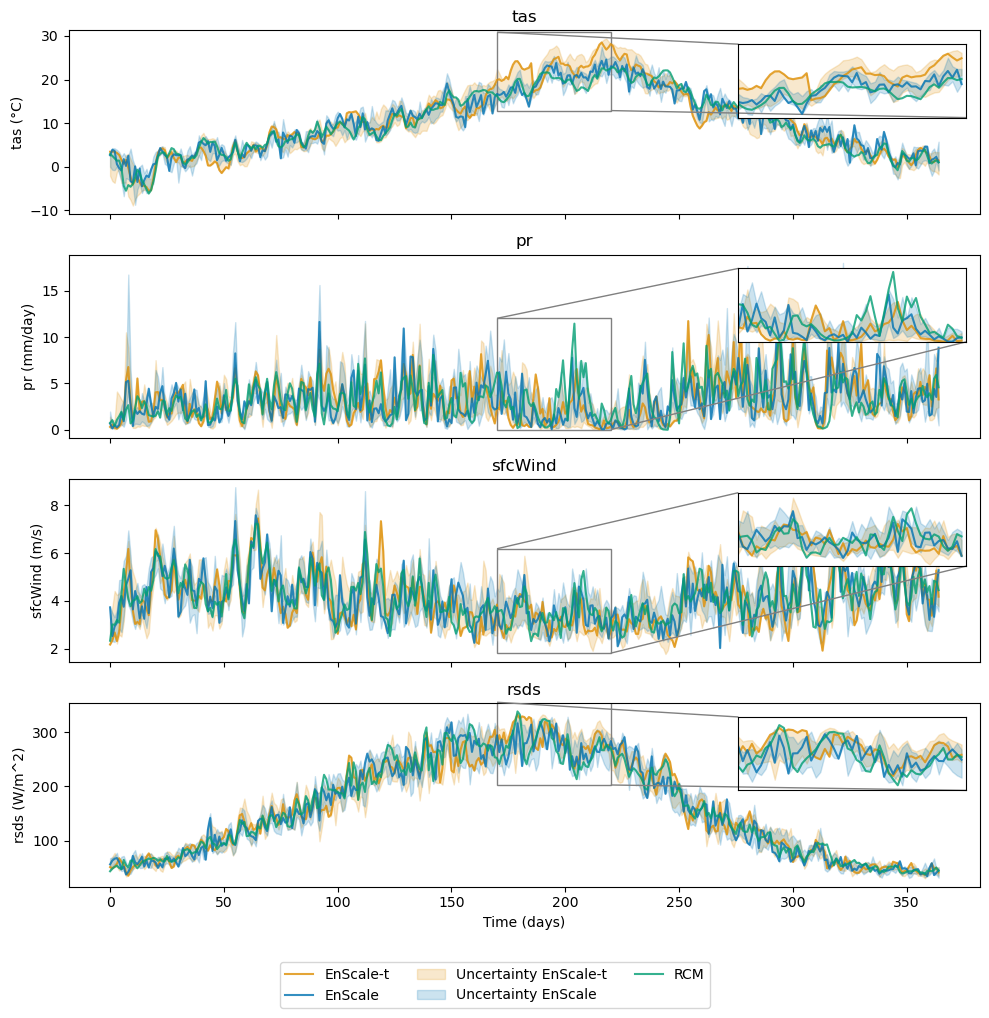

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
colorblind_palette = sns.color_palette("colorblind")
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
y = 3
units_dict = {
    "tas": "°C", 
    "pr": "mm/day", 
    "sfcWind": "m/s", 
    "rsds": "W/m^2"
}
start_ins = 170
end_ins = 220

for i, var in enumerate(["tas", "pr", "sfcWind", "rsds"]):
    sp_mean_temp = gen_data_subset[enscale_t_runid][var][y*365:(y+1)*365].mean(axis=(1, 2))
    sp_mean_marg = gen_data_subset[enscale_runid][var][y*365:(y+1)*365].mean(axis=(1, 2))
    sp_mean_true = true_data[var][y*365:(y+1)*365].mean(axis=(1, 2))

    days = np.arange(sp_mean_temp.shape[0])
    axs[i].plot(sp_mean_temp[:, 0], label="EnScale-t", alpha=0.8, color=colorblind_palette[1])
    axs[i].plot(sp_mean_marg[:, 0], label="EnScale", alpha=0.8, color=colorblind_palette[0])
    axs[i].fill_between(days, sp_mean_temp.min(axis=-1), sp_mean_temp.max(axis=-1), alpha=0.2, label="Uncertainty EnScale-t", color=colorblind_palette[1])
    axs[i].fill_between(days, sp_mean_marg.min(axis=-1), sp_mean_marg.max(axis=-1), alpha=0.2, label="Uncertainty EnScale", color=colorblind_palette[0])
    axs[i].plot(sp_mean_true, label="RCM", alpha=0.8, color=colorblind_palette[2])
    axs[i].set_ylabel(f"{var} ({units_dict[var]})")
    axs[i].set_title(var)

    # Add inset
    axins = inset_axes(axs[i], width="25%", height="40%", loc='upper right', borderpad=1)
    zoom_slice = slice(start_ins, end_ins)
    zoom_days = days[zoom_slice]
    axins.plot(zoom_days, sp_mean_temp[zoom_slice, 0], alpha=0.8, color=colorblind_palette[1])
    axins.plot(zoom_days, sp_mean_marg[zoom_slice, 0], alpha=0.8, color=colorblind_palette[0])
    axins.fill_between(zoom_days, sp_mean_temp[zoom_slice].min(axis=-1), sp_mean_temp[zoom_slice].max(axis=-1), alpha=0.2, color =colorblind_palette[1])
    axins.fill_between(zoom_days, sp_mean_marg[zoom_slice].min(axis=-1), sp_mean_marg[zoom_slice].max(axis=-1), alpha=0.2, color=colorblind_palette[0])
    axins.plot(zoom_days, sp_mean_true[zoom_slice], alpha=0.8, color=colorblind_palette[2])

    # Set limits on inset
    axins.set_xlim(start_ins, end_ins)
    axins.set_ylim(
        min(sp_mean_true[zoom_slice].min(), sp_mean_temp[zoom_slice].min(), sp_mean_marg[zoom_slice].min()) * 0.95,
        max(sp_mean_true[zoom_slice].max(), sp_mean_temp[zoom_slice].max(), sp_mean_marg[zoom_slice].max()) * 1.05
    )
    axins.set_xticks([])
    axins.set_yticks([])
    axins.tick_params(bottom=False, left=False)
    # axins.set_xticks([300, 305, 310])
    #axins.tick_params(labelsize=8)
    #axins.set_title("Zoom", fontsize=9)

    # Draw rectangle + connectors
    mark_inset(axs[i], axins, loc1=2, loc2=4, fc="none", ec="gray", lw=1)

# Only bottom plot gets x-label
axs[-1].set_xlabel("Time (days)")

# Shared legend below all
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=3)

fig.tight_layout(rect=[0, 0.05, 1, 1])
#plt.savefig(f"figures/time_series_colorblind_{version_name}.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Choose a threshold strategy:
# Option 1: Fixed threshold (you can tune this)
## threshold = 1.0  

for var in variables:
    print(var)
    sp_mean_temp = gen_data_subset[enscale_t_runid][var].mean(axis=(1, 2))
    sp_mean_marg = gen_data_subset[enscale_runid][var].mean(axis=(1, 2))
    sp_mean_true = true_data[var].mean(axis=(1, 2))
    std_dev = sp_mean_temp.std(axis=-1)
    threshold = 2.5 * std_dev  # 2-sigma rule

    # Compute daily stats
    ensemble_mean = sp_mean_temp.mean(axis=-1)
    ensemble_min = sp_mean_temp.min(axis=-1)
    ensemble_max = sp_mean_temp.max(axis=-1)

    # Max deviation from the mean
    max_deviation = np.maximum(
        np.abs(ensemble_mean - ensemble_min),
        np.abs(ensemble_max - ensemble_mean)
    )

    # Count outlier days
    outlier_days = np.where(max_deviation > threshold)[0]
    print(f"Number of outlier days: {len(outlier_days)}")
    
    # Repeat for marginal model
    ensemble_mean_marg = sp_mean_marg.mean(axis=-1)
    ensemble_min_marg = sp_mean_marg.min(axis=-1)
    ensemble_max_marg = sp_mean_marg.max(axis=-1)
    max_deviation_marg = np.maximum(
        np.abs(ensemble_mean_marg - ensemble_min_marg),
        np.abs(ensemble_max_marg - ensemble_mean_marg)
    )
    outlier_days_marg = np.where(max_deviation_marg > threshold)[0]
    print(f"Number of outlier days (marginal): {len(outlier_days_marg)}")


tas
Number of outlier days: 104
Number of outlier days (marginal): 1623
pr
Number of outlier days: 125
Number of outlier days (marginal): 888
sfcWind
Number of outlier days: 116
Number of outlier days (marginal): 1104
rsds
Number of outlier days: 101
Number of outlier days (marginal): 1081


## With CorrDiff

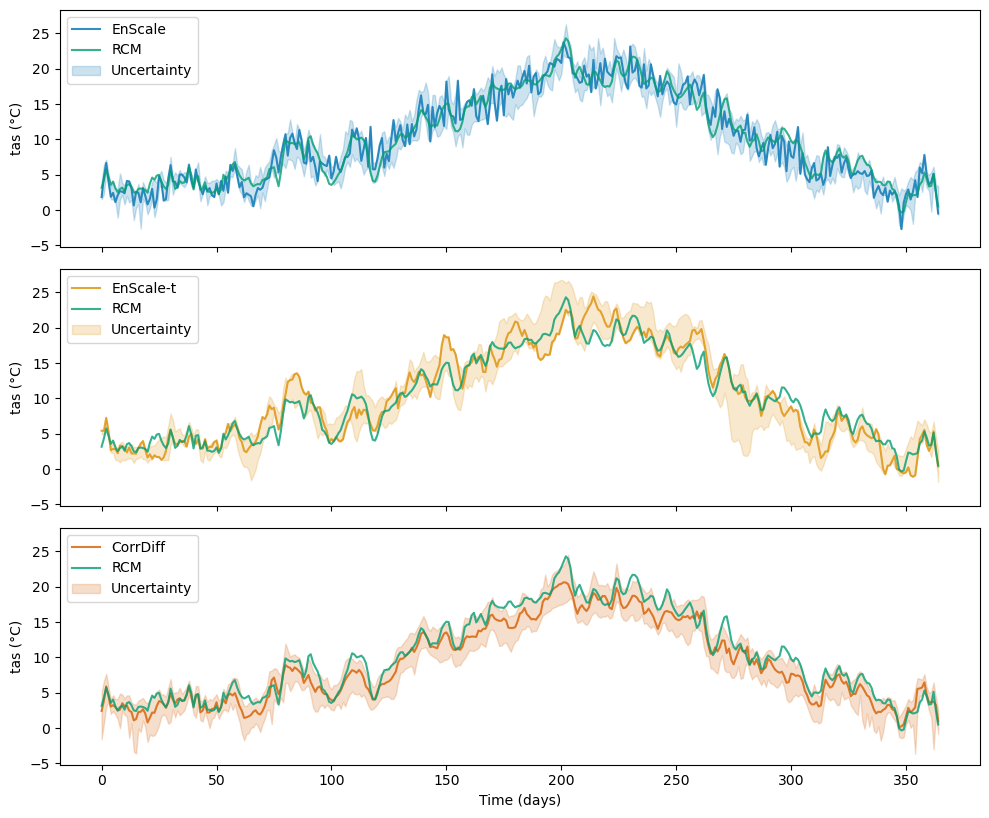

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

colorblind_palette = sns.color_palette("colorblind")
colors_dict = {
    "EnScale": colorblind_palette[0],
    "EnScale-t": colorblind_palette[1],
    "CorrDiff": colorblind_palette[3],
    "CorrDiff-s": colorblind_palette[4],
    "RCM": colorblind_palette[2],
}

units_dict = {
    "tas": "°C", 
    "pr": "mm/day", 
    "sfcWind": "m/s", 
    "rsds": "W/m^2"
}

y = 0
timesteps = np.arange(y * 365, (y + 1) * 365)
days = np.arange(len(timesteps))
var = "tas"

# Extract data
sp_mean_temp = gen_data_subset[enscale_t_runid][var][timesteps].mean(axis=(1, 2))
sp_mean_marg = gen_data_subset[enscale_runid][var][timesteps].mean(axis=(1, 2))
sp_mean_corrdiff = gen_data_subset["corrdiff_fixed-seeds"][var][timesteps, ..., :9].mean(axis=(1, 2))
sp_mean_corrdiff_stoch = gen_data_subset["corrdiff"][var][timesteps, ..., :9].mean(axis=(1, 2))
sp_mean_true = true_data[var][timesteps].mean(axis=(1, 2))

# Prepare figure
fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2)

# === Panel 1: EnScale ===
axs[0].plot(sp_mean_marg[:, 0], label="EnScale", alpha=0.8, color=colors_dict["EnScale"])
axs[0].plot(sp_mean_true, label="RCM", alpha=0.8, color=colors_dict["RCM"])
axs[0].fill_between(days, sp_mean_marg.min(axis=-1), sp_mean_marg.max(axis=-1), alpha=0.2, label="Uncertainty", color=colors_dict["EnScale"])
axs[0].set_ylabel(f"{var} ({units_dict[var]})")
axs[0].legend(loc="upper left")

# === Panel 2: EnScale-t ===s
axs[1].plot(sp_mean_temp[:, 0], label="EnScale-t", alpha=0.8, color=colors_dict["EnScale-t"])
axs[1].plot(sp_mean_true, label="RCM", alpha=0.8, color=colors_dict["RCM"])
axs[1].fill_between(days, sp_mean_temp.min(axis=-1), sp_mean_temp.max(axis=-1), alpha=0.2, label="Uncertainty", color=colors_dict["EnScale-t"])
axs[1].set_ylabel(f"{var} ({units_dict[var]})")
axs[1].legend(loc="upper left")

# === Panel 3: CorrDiff ===
axs[2].plot(sp_mean_corrdiff[:, 0], label="CorrDiff", alpha=0.8, color=colors_dict["CorrDiff"])
axs[2].plot(sp_mean_true, label="RCM", alpha=0.8, color=colors_dict["RCM"])
axs[2].fill_between(days, sp_mean_corrdiff.min(axis=-1), sp_mean_corrdiff.max(axis=-1), alpha=0.2, label="Uncertainty", color=colors_dict["CorrDiff"])
axs[2].set_ylabel(f"{var} ({units_dict[var]})")
axs[2].set_xlabel("Time (days)")
axs[2].legend(loc="upper left")

# Final layout tweaks
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(f"figures/time_series_three_panels_{version_name}.png", dpi=300, bbox_inches="tight")
plt.show()